In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")


def plot_1d_regression(
    x_star,
    gpm,
    ax=None,
    f_true=None,
    num_samples=10
):
    """Plot the posterior predictive.
    
    Arguments
    x_start  --  The test points on which to evaluate.
    gpm      --  The trained model.
    
    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    """
    m_star, v_star = gpm.predict(x_star)

    f_lower = (
        m_star - 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
    )
    f_upper = (
        m_star + 2.0 * np.sqrt(v_star - gpm.likelihood.variance)
    )
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(x_star, m_star, lw=2, label='$m_n(x)$')
   
    ax.fill_between(
        x_star.flatten(),
        f_lower.flatten(),
        f_upper.flatten(),
        alpha=0.5,
        label='$f(\mathbf{x}^*)$ 95% pred.'
    )
    
    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = gpm.posterior_samples_f(
            x_star,
            num_samples
        )
        ax.plot(x_star, f_post_samples[:, 0, :], 'r', lw=0.5)
        ax.plot([], [], 'r', lw=0.5, label="Posterior samples")

    ax.plot(gpm.X,
            gpm.Y,
            'kx',
            markersize=5,
            markeredgewidth=2,
            label='Observations'
    )

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    plt.legend(loc='best');

# Maximum Mean - A Bad Information Acquisition Function

## Objectives

+ Develop intuition about the maximum mean as an information acquisition function and why you should never use it.

## Working 1D Example

It is easier to introduce the ideas using an example.
Let's work with a synthetic 1D function defined in $[0,1]$:

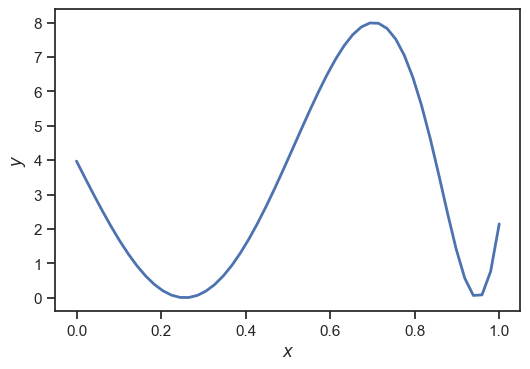

In [2]:
def f(x):
    """A function to optimize."""
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

x = np.linspace(0, 1)
plt.plot(x, f(x), linewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$');

We wish to maximize this function (of course, in reality, you wouldn't see the functioin).
Let us generate some starting data:

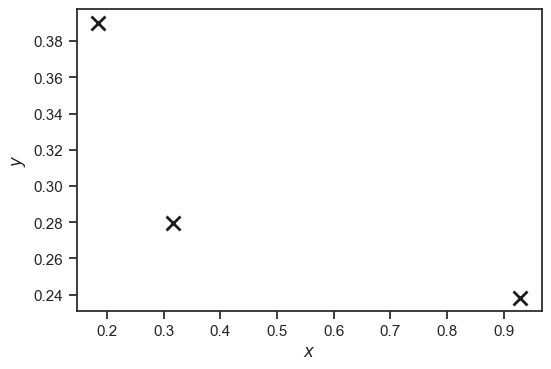

In [3]:
np.random.seed(12345)

n_init = 3

X = np.random.rand(n_init)
Y = f(X)

plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$');

Assume that we do some kind of Bayesian regression, using the data we have so far.
Here, we will do GPR, but any Bayesian regression would actually work.
We will not work right now with the full predictive $p(f(\cdot)|\mathcal{D}_{n})$, but with the point-predictive distribution:
$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$
where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.

Here is an example with GPR:

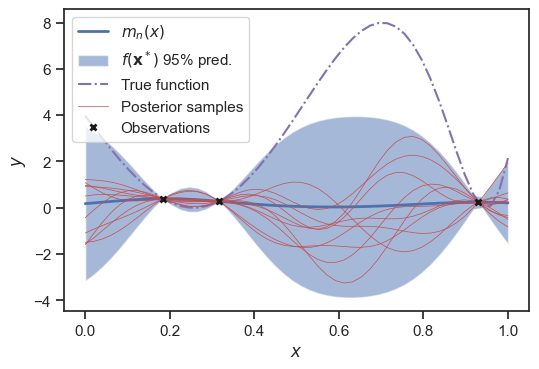

In [4]:
import GPy

k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(1e-16)

plot_1d_regression(x[:, None], gpr, f_true=f)

Now, the question is this: "Where should we evaluate the function next if our goal is to maximize the function?"
Let's start with the naive assumption that we should evaluate the function at the point that maximizes the Gaussian process posterior mean, i.e., wherever is the max of the thick blue line.
In other words, the information acquisition function is the posterior mean of the Gaussian process.
Let's see what happens.

In [5]:
def maximize_naive(f, gpr, X_design, max_it=6):
    """
    Optimize f using a limited number of evaluations.
    
    Arguments
    :param f:        The function to optimize.
    :param gpr:      A Gaussian process model to use for representing our state of knowldege.
    :param X_design: The set of candidate points for identifying the maximum.
    :param max_it:   The maximum number of iterations.
    """
    for count in range(max_it):
        m, sigma2 = gpr.predict(X_design)
        
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        gpr.set_XY(X, y)
        
        fig, ax = plt.subplots()
        plot_1d_regression(
            X_design,
            gpr,
            ax=ax,
            f_true=f,
            num_samples=0
        )
        ax.plot(x[i], f(x[i]), 'go', label='Next observation')
        ax.set_title('BGO iteration #{0:d}'.format(count+1))
        plt.legend(loc='best')

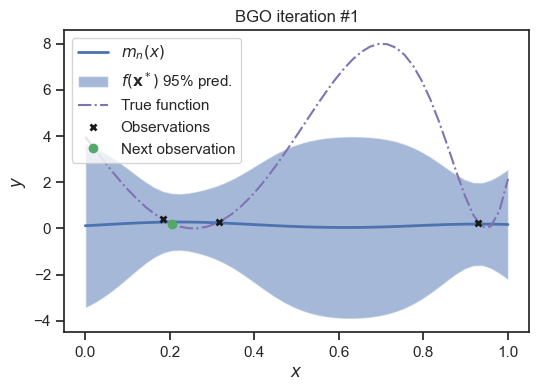

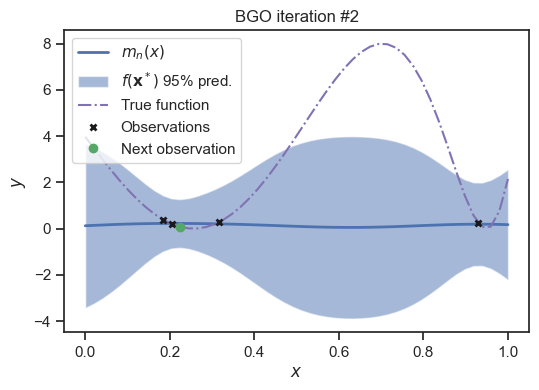

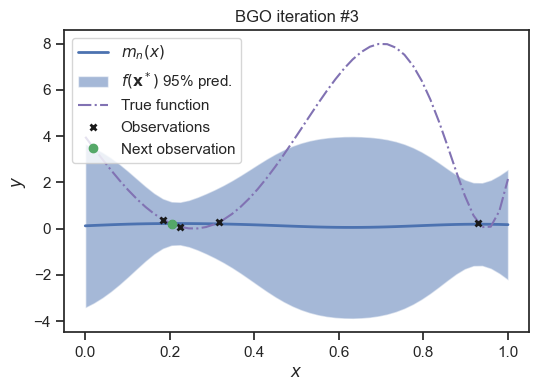

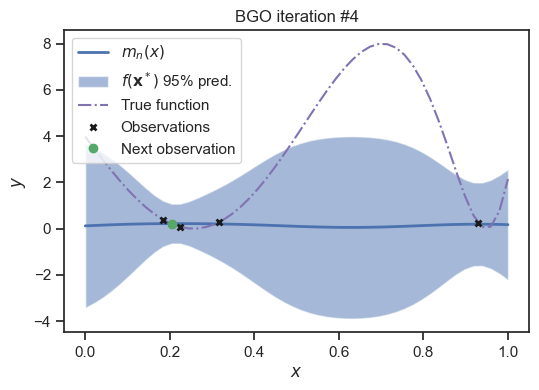

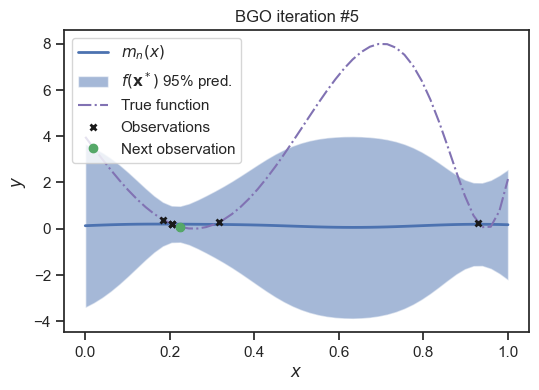

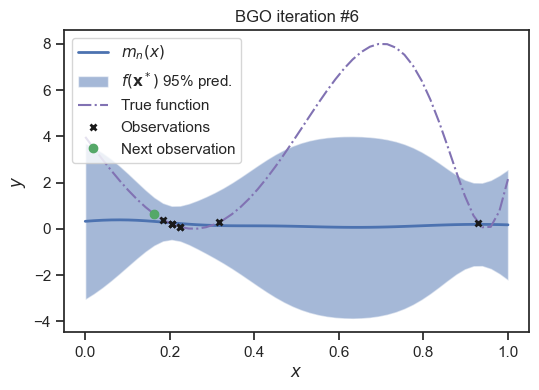

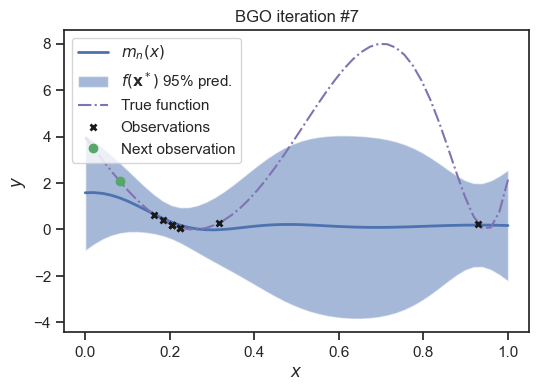

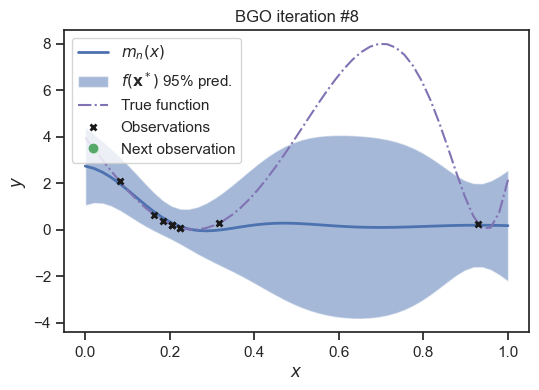

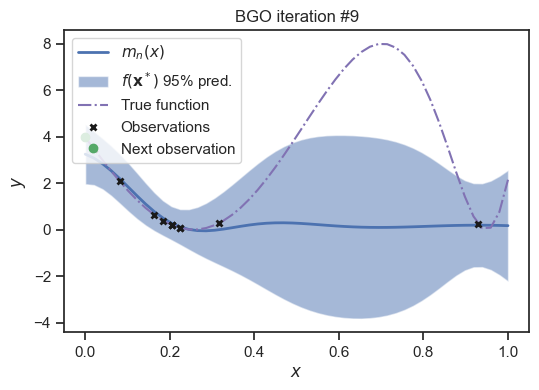

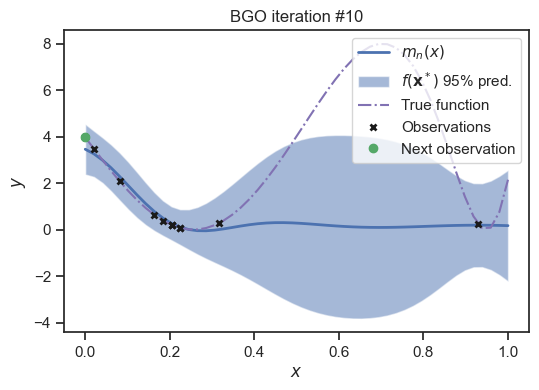

In [6]:
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
maximize_naive(f, gpr, x[:, None], max_it=10)

Observe that the algorithm misses the real maximum.
It gets trapped.
This is because using the posterior mean as an acquisition functions focuses too much on **exploiting** the current available information but fails to **explore** regions of the input space that we haven't visited.

### Questions

+ Experiment with different number of initial observations. How many do you have to use for the algorithm to actually converge to the global maximum?